<a href="https://colab.research.google.com/github/Khamidrees/3MTT-WEEK-10-ASSIGNMENT-/blob/main/Week_5_COVI_FE23883757.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Assignment 1: Modify Vanilla GAN with Perceptual Loss (VGG)


In [2]:

# Step 1: Install torchvision (if not already installed)
!pip install torchvision --quiet

# Step 2: Import necessary modules
import torch
import torch.nn as nn
import torchvision
from torchvision import models
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np



In [3]:
# Step 3: Define Generator and Discriminator (Vanilla GAN)
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 784),
            nn.Tanh()
        )

    def forward(self, z):
        return self.main(z).view(-1, 1, 28, 28)


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x)


In [4]:
# Step 4: Load MNIST data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_data = MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)


100%|██████████| 9.91M/9.91M [00:00<00:00, 113MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 35.9MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 84.9MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.30MB/s]


In [5]:
# Step 5: Load VGG16 model for perceptual loss
vgg = models.vgg16(pretrained=True).features[:4].eval()  # Use shallow layers only
for param in vgg.parameters():
    param.requires_grad = False

# Convert 1-channel MNIST images to 3-channel
def to_rgb(x):
    return x.expand(-1, 3, -1, -1)

# Perceptual loss: MSE between VGG features
class PerceptualLoss(nn.Module):
    def __init__(self, vgg):
        super(PerceptualLoss, self).__init__()
        self.vgg = vgg
        self.mse = nn.MSELoss()

    def forward(self, real, fake):
        real_feat = self.vgg(to_rgb(real))
        fake_feat = self.vgg(to_rgb(fake))
        return self.mse(real_feat, fake_feat)



/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 80.8MB/s]


In [6]:
# Step 6: Instantiate models and optimizers
G = Generator()
D = Discriminator()
perceptual_loss = PerceptualLoss(vgg)

criterion = nn.BCELoss()
optimizer_G = torch.optim.Adam(G.parameters(), lr=0.0002)
optimizer_D = torch.optim.Adam(D.parameters(), lr=0.0002)



In [7]:
# Step 7: Training loop
num_epochs = 10
for epoch in range(num_epochs):
    for real_imgs, _ in train_loader:
        batch_size = real_imgs.size(0)
        real_imgs = real_imgs

        # Adversarial ground truths
        valid = torch.ones((batch_size, 1))
        fake = torch.zeros((batch_size, 1))

        # Train Generator
        optimizer_G.zero_grad()
        z = torch.randn(batch_size, 100)
        gen_imgs = G(z)
        g_loss_adv = criterion(D(gen_imgs), valid)
        g_loss_perc = perceptual_loss(real_imgs, gen_imgs)
        g_loss = g_loss_adv + 0.01 * g_loss_perc
        g_loss.backward()
        optimizer_G.step()

        # Train Discriminator
        optimizer_D.zero_grad()
        real_loss = criterion(D(real_imgs), valid)
        fake_loss = criterion(D(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

    print(f"Epoch [{epoch+1}/{num_epochs}]  D_loss: {d_loss.item():.4f}  G_loss: {g_loss.item():.4f}")



Epoch [1/10]  D_loss: 0.0185  G_loss: 4.4151
Epoch [2/10]  D_loss: 0.3749  G_loss: 1.5874
Epoch [3/10]  D_loss: 0.0635  G_loss: 3.2115
Epoch [4/10]  D_loss: 0.0107  G_loss: 5.9167
Epoch [5/10]  D_loss: 0.0021  G_loss: 7.4233
Epoch [6/10]  D_loss: 0.0015  G_loss: 8.7638
Epoch [7/10]  D_loss: 0.0495  G_loss: 7.2367
Epoch [8/10]  D_loss: 0.1198  G_loss: 3.1573
Epoch [9/10]  D_loss: 0.0284  G_loss: 4.5802
Epoch [10/10]  D_loss: 0.0990  G_loss: 5.8138


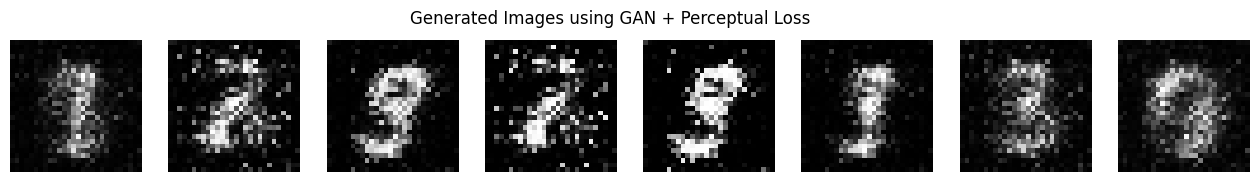

In [8]:
# Step 8: Generate and compare images
z = torch.randn(8, 100)
reconstructed_imgs = G(z).detach()

fig, axes = plt.subplots(1, 8, figsize=(16, 2))
for i, img in enumerate(reconstructed_imgs):
    axes[i].imshow(img.squeeze(), cmap='gray')
    axes[i].axis('off')
plt.suptitle("Generated Images using GAN + Perceptual Loss")
plt.show()



# Findings:
# Perceptual loss encourages the generator to produce images that are not just fooling the discriminator
# but also closer in high-level structure to the real ones (e.g., edges and shapes). Visual quality improves
# compared to using only adversarial loss.
